In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns

In [2]:
# Load the loan data
loan_all_df = pd.read_csv("loan.csv", low_memory=False)
loan_all_df.shape

(39717, 111)

In [3]:
loan_all_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,...,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,...,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,...,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
75%,8.377550e+05,1.047339e+06,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,...,NaN,NaN,NaN,NaN,2.000000,0.0,NaN,NaN,NaN,NaN


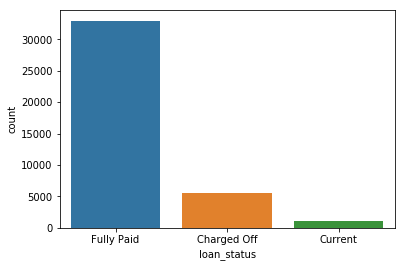

In [4]:
sns.countplot(loan_all_df.loan_status)

In [5]:
# Keep only the rows where loan_status is not Current
loan_df = loan_all_df.loc[loan_all_df.loan_status != 'Current']
loan_df.shape

(38577, 111)

In [6]:
# Find out percentage of missing values in each column
columns = loan_df.columns
percent_missing = loan_df.isnull().sum() * 100 / len(loan_df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False, inplace=True)
missing_value_df[missing_value_df.percent_missing == 100]

,column_name,percent_missing
verification_status_joint,verification_status_joint,100.0
annual_inc_joint,annual_inc_joint,100.0
mo_sin_old_rev_tl_op,mo_sin_old_rev_tl_op,100.0
mo_sin_old_il_acct,mo_sin_old_il_acct,100.0
bc_util,bc_util,100.0
bc_open_to_buy,bc_open_to_buy,100.0
avg_cur_bal,avg_cur_bal,100.0
acc_open_past_24mths,acc_open_past_24mths,100.0
inq_last_12m,inq_last_12m,100.0
total_cu_tl,total_cu_tl,100.0


In [7]:
# list the columns that have 100% missing values
list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name'])

['verification_status_joint',
 'annual_inc_joint',
 'mo_sin_old_rev_tl_op',
 'mo_sin_old_il_acct',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'inq_last_12m',
 'total_cu_tl',
 'inq_fi',
 'total_rev_hi_lim',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'tot_cur_bal',
 'tot_coll_amt',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'total_bal_ex_mort',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_sats',
 'num_rev_accts',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_il_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'num_accts_ever_120_pd',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_inq',
 'mths_since_recent_bc_dlq',
 'dti_joint',
 '

In [8]:
# drop columns that have 100% mising values
loan_df.drop(columns=list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name']),inplace = True)
loan_df.shape

C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(38577, 56)

In [9]:
# find out columns that have 0 standard deviation
loan_df.std() == 0.0

id                            False
member_id                     False
loan_amnt                     False
funded_amnt                   False
funded_amnt_inv               False
installment                   False
annual_inc                    False
dti                           False
delinq_2yrs                   False
inq_last_6mths                False
mths_since_last_delinq        False
mths_since_last_record        False
open_acc                      False
pub_rec                       False
revol_bal                     False
total_acc                     False
out_prncp                      True
out_prncp_inv                  True
total_pymnt                   False
total_pymnt_inv               False
total_rec_prncp               False
total_rec_int                 False
total_rec_late_fee            False
recoveries                    False
collection_recovery_fee       False
last_pymnt_amnt               False
collections_12_mths_ex_med     True
policy_code                 

In [10]:
# find out columns that have 0 standard deviation
loan_df.std()[loan_df.std() == 0.0]

out_prncp                     0.0
out_prncp_inv                 0.0
collections_12_mths_ex_med    0.0
policy_code                   0.0
acc_now_delinq                0.0
chargeoff_within_12_mths      0.0
delinq_amnt                   0.0
tax_liens                     0.0
dtype: float64

In [11]:
# dropping column with standard deviation 0
loan_df.drop(loan_df.std()[loan_df.std() == 0.0].index.values, axis=1,inplace = True)
loan_df.shape

(38577, 48)

In [12]:
# checking whether there are columns having single values. Standard deviation check will not work for non-numeric columns
uniques = loan_df.apply(lambda x: x.nunique())
uniques[uniques==1]

pymnt_plan             1
initial_list_status    1
application_type       1
dtype: int64

In [13]:
# dropping columns having single values
loan_df = loan_df.drop(uniques[uniques==1].index, axis=1)
loan_df.shape

(38577, 45)

In [14]:
# checking whether there are duplicate rows
loan_df.duplicated().sum()

0

In [15]:
# Will delete from final
# detecting numeric and non-numeric columns
cols = loan_df.columns
num_cols = loan_df._get_numeric_data().columns
print('List of Numeric columns')
print(num_cols)

not_num_cols = list(set(cols) - set(num_cols))
print('Non-Numeric columns')
print(not_num_cols)

List of Numeric columns
Index(['id', 'member_id', 'loan_amnt', 'funded_amnt', 'funded_amnt_inv',
       'installment', 'annual_inc', 'dti', 'delinq_2yrs', 'inq_last_6mths',
       'mths_since_last_delinq', 'mths_since_last_record', 'open_acc',
       'pub_rec', 'revol_bal', 'total_acc', 'total_pymnt', 'total_pymnt_inv',
       'total_rec_prncp', 'total_rec_int', 'total_rec_late_fee', 'recoveries',
       'collection_recovery_fee', 'last_pymnt_amnt', 'pub_rec_bankruptcies'],
      dtype='object')
Non-Numeric columns
['emp_title', 'url', 'last_credit_pull_d', 'desc', 'addr_state', 'loan_status', 'sub_grade', 'grade', 'verification_status', 'int_rate', 'zip_code', 'revol_util', 'purpose', 'last_pymnt_d', 'issue_d', 'term', 'home_ownership', 'title', 'earliest_cr_line', 'emp_length']


In [16]:
# Will delete from final
# read in data dictionary
data_dict = pd.read_csv('Data_Dictionary.csv', encoding = 'latin-1')
data_dict.head()

,LoanStatNew,Description
0,acc_now_delinq,The number of accounts on which the borrower i...
1,acc_open_past_24mths,Number of trades opened in past 24 months.
2,addr_state,The state provided by the borrower in the loan...
3,all_util,Balance to credit limit on all trades
4,annual_inc,The self-reported annual income provided by th...


In [17]:
# Will delete from final
# subset data dictionary for the reduced columns in data dictionary 
data_dict_reduced = data_dict.loc[data_dict['LoanStatNew'].isin(loan_df.columns)]
data_dict_reduced.loc[:,'data_type'] = data_dict_reduced['LoanStatNew'].apply(lambda x: 'Numeric' if x in num_cols else 'Not-Numeric')
data_dict_reduced.shape

C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


(45, 3)

In [18]:
# Will delete from final
# write reduced data dictionary to a csv file.
data_dict_reduced.to_csv('data_dict_reduced.csv')
data_dict_reduced.head()

,LoanStatNew,Description,data_type
2,addr_state,The state provided by the borrower in the loan...,Not-Numeric
4,annual_inc,The self-reported annual income provided by th...,Numeric
11,collection_recovery_fee,post charge off collection fee,Numeric
13,delinq_2yrs,The number of 30+ days past-due incidences of ...,Numeric
15,desc,Loan description provided by the borrower,Not-Numeric


In [19]:
# Check potential unique value fields 
df_colunique = pd.DataFrame(loan_df.nunique()/loan_df.count())
# Columns having all unique values excludeing Nulls
df_colunique.loc[df_colunique[0] >= 0.99]

,0
id,1.000000
member_id,1.000000
url,1.000000
desc,0.990518


In [20]:
# drop the columns where each row has unique values
loan_df.drop(df_colunique.loc[df_colunique[0] >= 0.99].index, axis=1, inplace= True)
loan_df.shape

(38577, 41)

In [21]:
# identify columns which have no impact on the business or which do not give additional information 

columns_to_remove = ['title' , 'collection_recovery_fee']
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 39)

In [22]:
# Strip all columns for leading and lagging spaces

loan_df = loan_df.applymap(lambda s : s.strip() if type(s) is str else s)

In [23]:
# Remove string months from term 6 

loan_df.term = loan_df.term.apply(lambda s : s[0:s.index(' ')] if ' ' in s else s)
loan_df.term = pd.to_numeric(loan_df.term)
loan_df.term.head()

0    36
1    60
2    36
3    36
5    36
Name: term, dtype: int64

In [24]:
# Remove % sign from interest rate 
loan_df.int_rate = loan_df.int_rate.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.int_rate = pd.to_numeric(loan_df.int_rate)
loan_df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: float64

In [25]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 39 columns):
loan_amnt                 38577 non-null int64
funded_amnt               38577 non-null int64
funded_amnt_inv           38577 non-null float64
term                      38577 non-null int64
int_rate                  38577 non-null float64
installment               38577 non-null float64
grade                     38577 non-null object
sub_grade                 38577 non-null object
emp_title                 36191 non-null object
emp_length                37544 non-null object
home_ownership            38577 non-null object
annual_inc                38577 non-null float64
verification_status       38577 non-null object
issue_d                   38577 non-null object
loan_status               38577 non-null object
purpose                   38577 non-null object
zip_code                  38577 non-null object
addr_state                38577 non-null object
dti                       

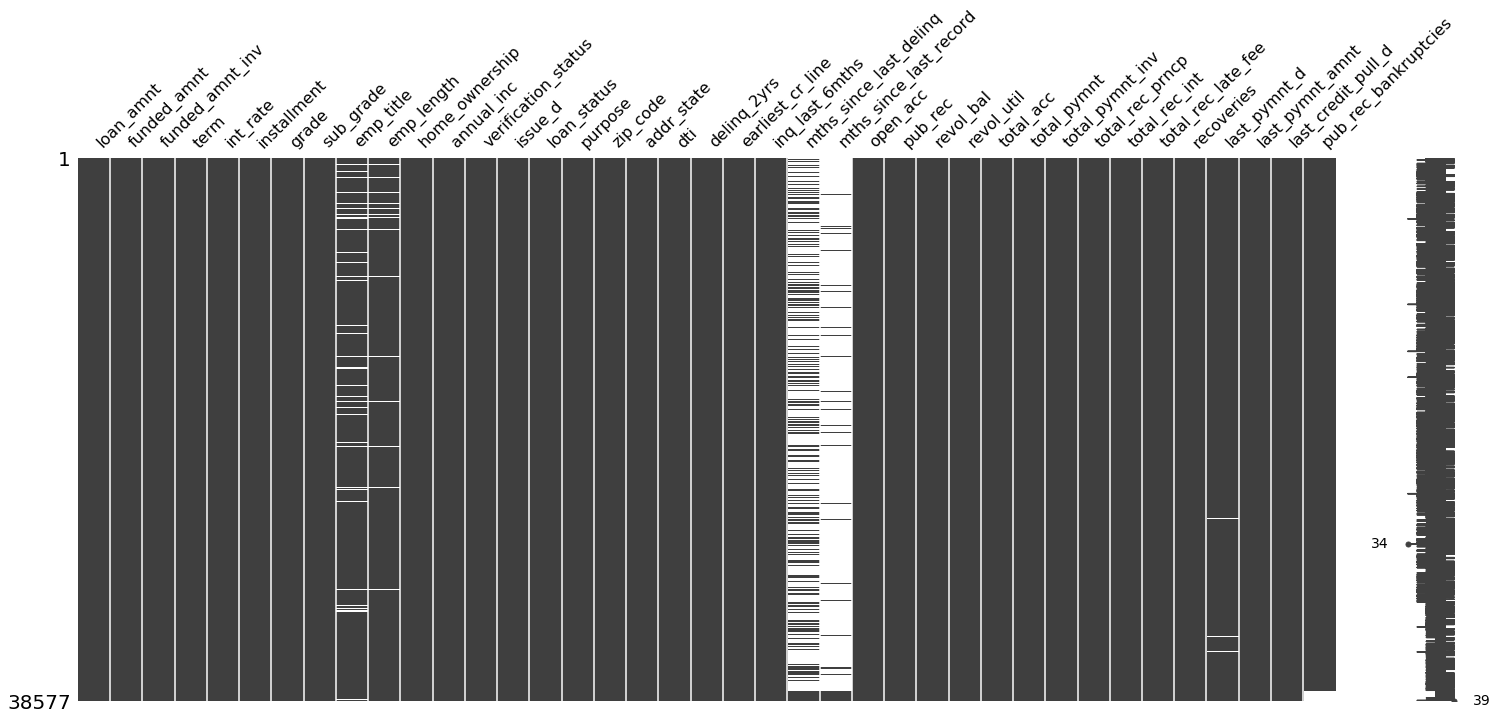

In [26]:
# visualize missing data
msno.matrix(loan_df)

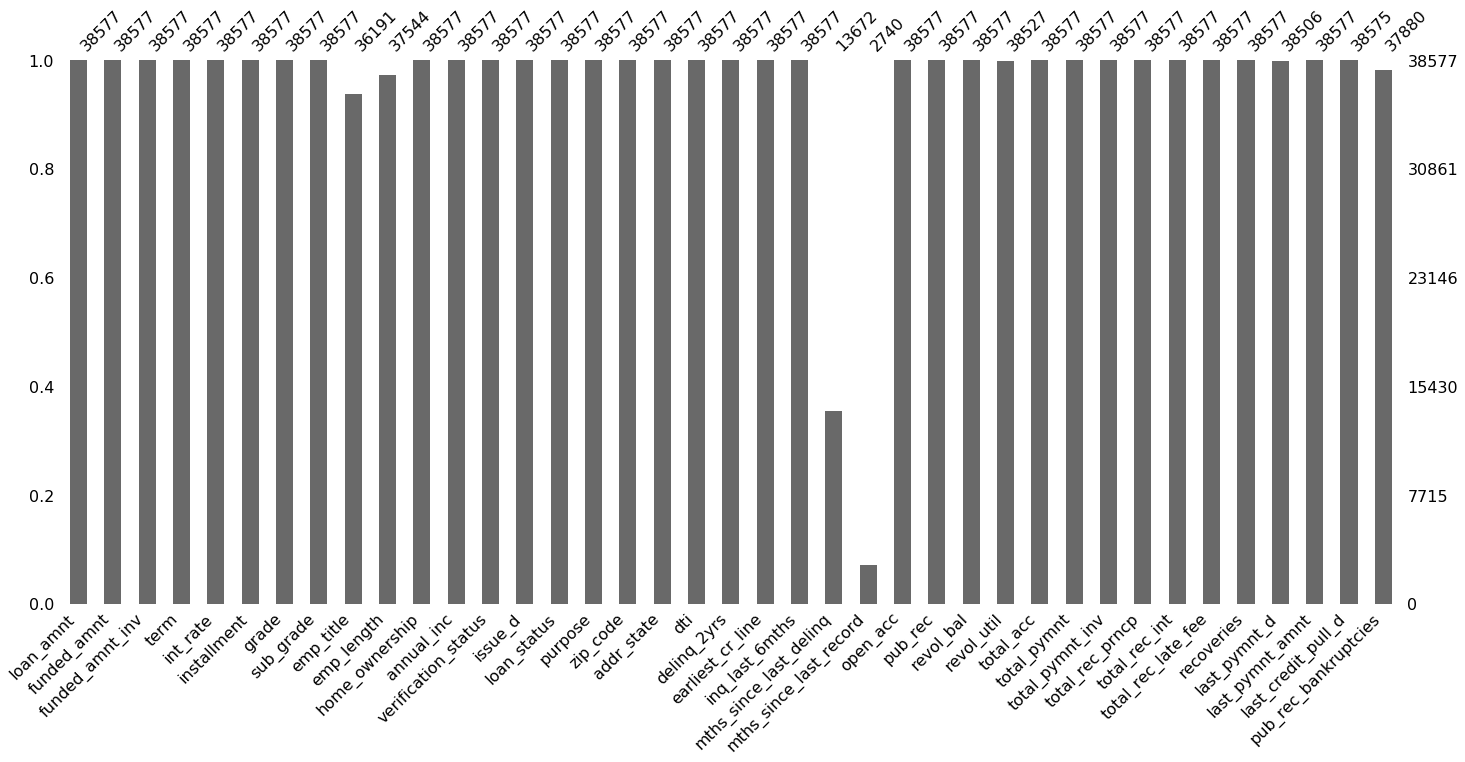

In [27]:
msno.bar(loan_df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

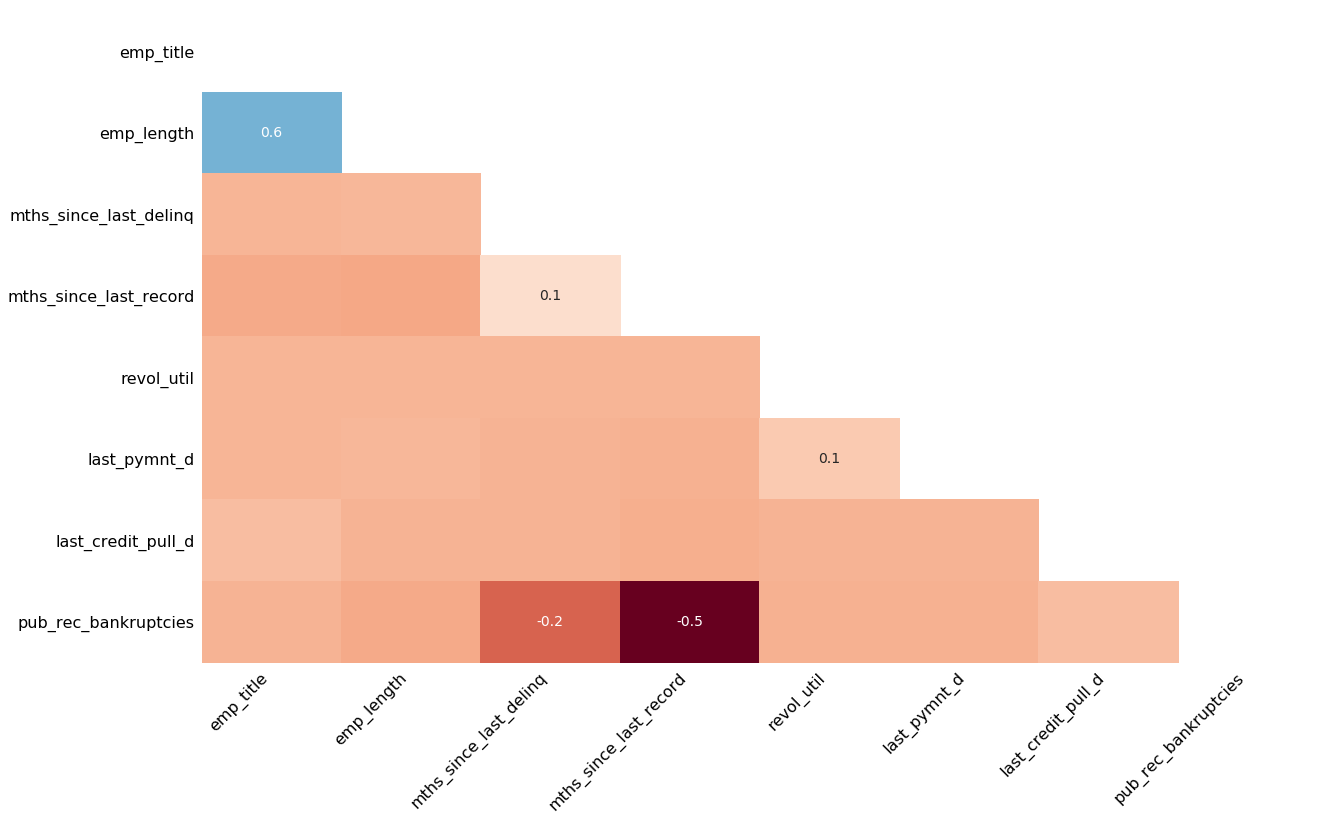

In [28]:
msno.heatmap(loan_df)

In [29]:
# writing load data frame with reduced columns in a csv
loan_df.to_csv('loan_df_reduced.csv')

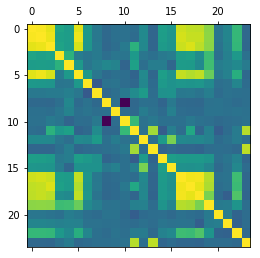

In [30]:
# Will delete from final
plt.matshow(loan_df.corr())

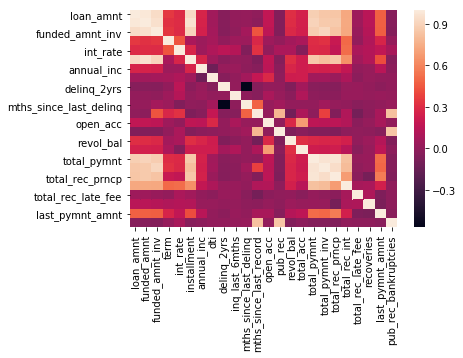

In [31]:
sns.heatmap(loan_df.corr())

In [32]:
loan_df.corr().style.background_gradient()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,total_acc,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,last_pymnt_amnt,pub_rec_bankruptcies
loan_amnt,1,0.98179,0.937922,0.34665,0.301265,0.93226,0.268999,0.0624358,-0.0319515,0.01294,0.0154397,-0.000768591,0.1772,-0.0499975,0.314022,0.256179,0.88191,0.847635,0.84587,0.728343,0.0471028,0.142789,0.474614,-0.0359812
funded_amnt,0.98179,1,0.956172,0.324893,0.30493,0.958035,0.264798,0.0621941,-0.0318661,0.0128569,0.0159689,-0.0111316,0.175682,-0.0505762,0.306501,0.250551,0.898709,0.864501,0.864082,0.736654,0.0494652,0.143452,0.478448,-0.036995
funded_amnt_inv,0.937922,0.956172,1,0.343922,0.297473,0.905464,0.251981,0.070663,-0.0381712,-0.00280027,0.0733665,0.439521,0.162738,-0.0514702,0.286265,0.242715,0.87473,0.909127,0.838587,0.726736,0.0293791,0.130997,0.469166,-0.0411932
term,0.34665,0.324893,0.343922,1,0.440206,0.0904558,0.0438658,0.076182,0.00727046,0.0477079,0.0386456,0.280084,0.0461625,0.0102661,0.0664109,0.0961683,0.305571,0.3209,0.200222,0.506258,0.0128498,0.112806,0.270192,0.0145287
int_rate,0.301265,0.30493,0.297473,0.440206,1,0.277203,0.0488991,0.110913,0.158479,0.133362,-0.0543071,0.325035,0.00602205,0.0986354,0.0941787,-0.046539,0.290661,0.284932,0.174717,0.521233,0.0943189,0.128596,0.174377,0.0830265
installment,0.93226,0.958035,0.905464,0.0904558,0.277203,1,0.267842,0.0520385,-0.0197554,0.0110144,0.000267504,-0.0642665,0.172893,-0.0457055,0.309501,0.22986,0.858493,0.817665,0.847762,0.642655,0.0583866,0.121463,0.413588,-0.0333606
annual_inc,0.268999,0.264798,0.251981,0.0438658,0.0488991,0.267842,1,-0.12153,0.0222289,0.0354651,-0.00744238,-0.0315529,0.156927,-0.017864,0.277374,0.234534,0.256313,0.245198,0.256848,0.185056,0.00681447,0.0221839,0.143242,-0.0162235
dti,0.0624358,0.0621941,0.070663,0.076182,0.110913,0.0520385,-0.12153,1,-0.033347,0.00217837,0.0687047,0.186637,0.287849,-0.00474244,0.22809,0.229119,0.0592738,0.0662768,0.0367551,0.103104,-0.0114121,0.0261624,0.00856619,0.00596645
delinq_2yrs,-0.0319515,-0.0318661,-0.0381712,0.00727046,0.158479,-0.0197554,0.0222289,-0.033347,1,0.00873341,-0.567607,-0.0373654,0.0116486,0.00762299,-0.0544373,0.0669943,-0.0231298,-0.029608,-0.0384471,0.0237777,0.028772,0.0124425,-0.0125112,0.00340418
inq_last_6mths,0.01294,0.0128569,-0.00280027,0.0477079,0.133362,0.0110144,0.0354651,0.00217837,0.00873341,1,-0.00585201,-0.0289663,0.0934343,0.0237263,-0.020787,0.113516,-0.0082439,-0.0185889,-0.0213279,0.0265492,0.0307406,0.0188992,0.0277724,0.0155171
